In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
import statsmodels.api as sm

In [13]:
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('/Users/temp/Downloads/ARIMA : SARIMA model project/Electric_Production.csv')

In [4]:
df.head()


,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


# Data analysis
1. Check for data types
2. Check for missing data
3. Check for duplicates
4. Converting date into index/ datetime

In [25]:
df.rename(columns={'IPG2211A2N':'Electricity_Usage'},inplace=True)

In [10]:
df.dtypes

IPG2211A2N    float64
dtype: object

In [11]:
df.isna().sum()

DATE          0
IPG2211A2N    0
dtype: int64

In [5]:
df.duplicated().sum()


0

In [7]:
df.set_index('DATE',inplace=True)

In [11]:
df.index = pd.to_datetime(df.index)

<AxesSubplot:xlabel='DATE'>

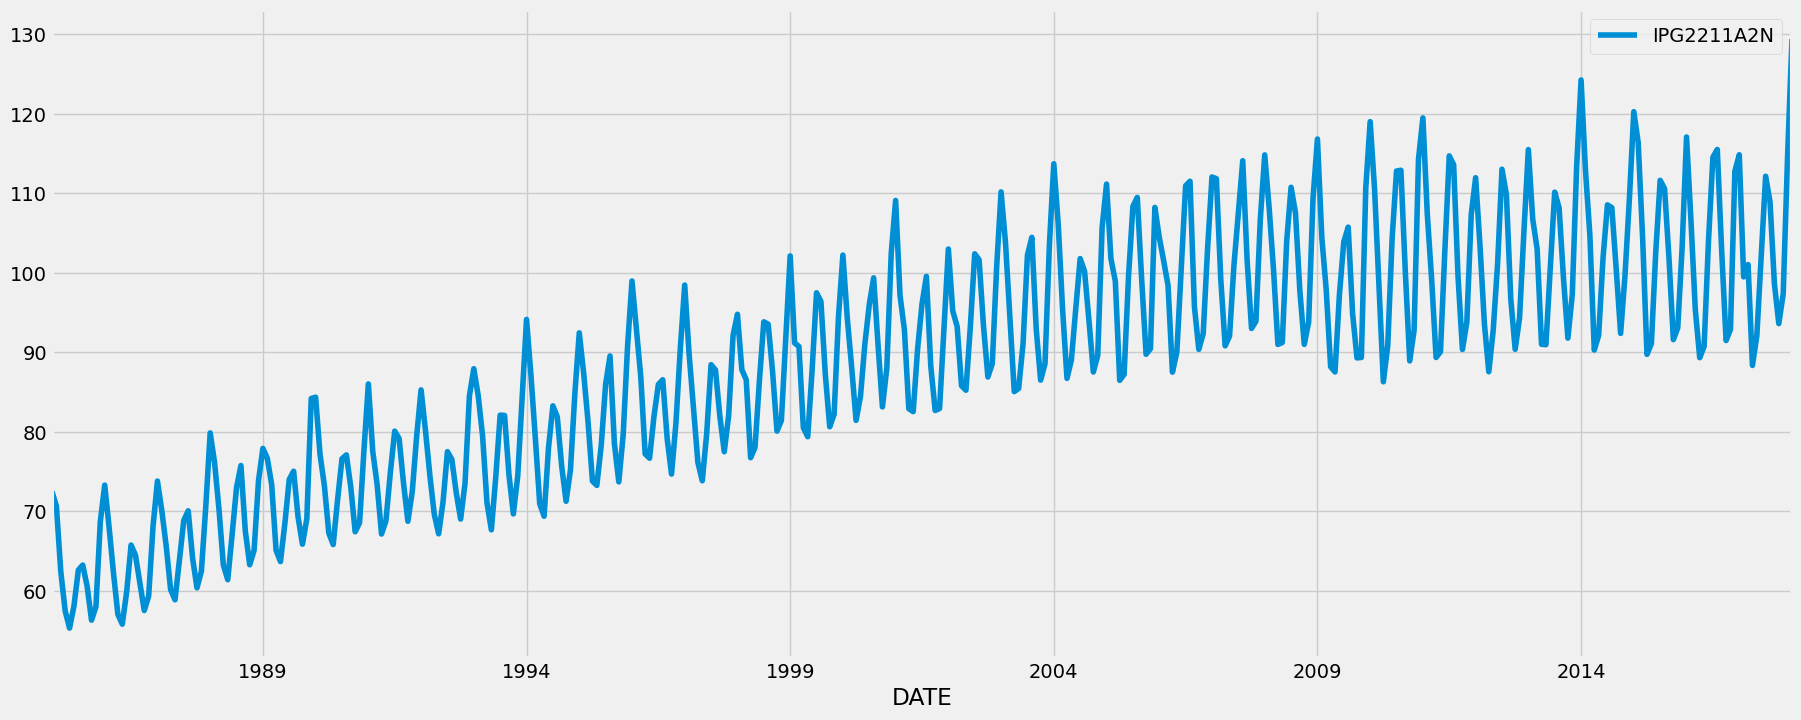

In [19]:
df.plot(figsize=(20,8))

# Stationarity check
1. Visual interpretation 
2. Augmented Dickey Fuller test

# Visual Interpretation
1. Statistical properties of the data is not consistent
    Moving means and variances across time
2. Seasonality
    Season based electricity consumption with consistent peaks and throughs 

In [20]:
#augmented dickey fuller test for stationarity
#import adfuller test

from statsmodels.tsa.stattools import adfuller

In [26]:
adfuller(df['Electricity_Usage'])

(-2.256990350047232,
 0.18621469116587197,
 15,
 381,
 {'1%': -3.4476305904172904,
  '5%': -2.869155980820355,
  '10%': -2.570827146203181},
 1840.8474501627156)

In [27]:
#Create function for more interpretable result by using labels

def adfuller_fit(data):
    test_results = adfuller(data)
    data_labels = ['Critical Values','p-value','Lags used','Observations Used','T-Values']
    for value,label in zip(test_results,data_labels):
        print(label + ':' + str(value))
    

In [28]:
adfuller_fit(df['Electricity_Usage'])

Critical Values:-2.256990350047232
p-value:0.18621469116587197
Lags used:15
Observations Used:381
T-Values:{'1%': -3.4476305904172904, '5%': -2.869155980820355, '10%': -2.570827146203181}


# since the adfuller is a hypothesis test, it is defined as:

- Null Hypothesis : The data is not stationary 
- Alternative Hypothesis: The data is stationary

- p-value: 0.18 > 0.05 (at 95 percent confident interval)
- null hypothesis cannot be rejected

In [29]:
# Differencing the data to stationarity 

#First order

df['One_Lag'] = df['Electricity_Usage'] - df['Electricity_Usage'].shift(1)


In [30]:
df.head()

,Electricity_Usage,One_Lag
DATE,,
1985-01-01,72.5052,NaN
1985-02-01,70.6720,-1.8332
1985-03-01,62.4502,-8.2218
1985-04-01,57.4714,-4.9788
1985-05-01,55.3151,-2.1563


In [32]:
# Using the general rule of lag=12 in accounting seasonality

df['Season_lag'] = df['Electricity_Usage'] - df['Electricity_Usage'].shift(12)

<AxesSubplot:xlabel='DATE'>

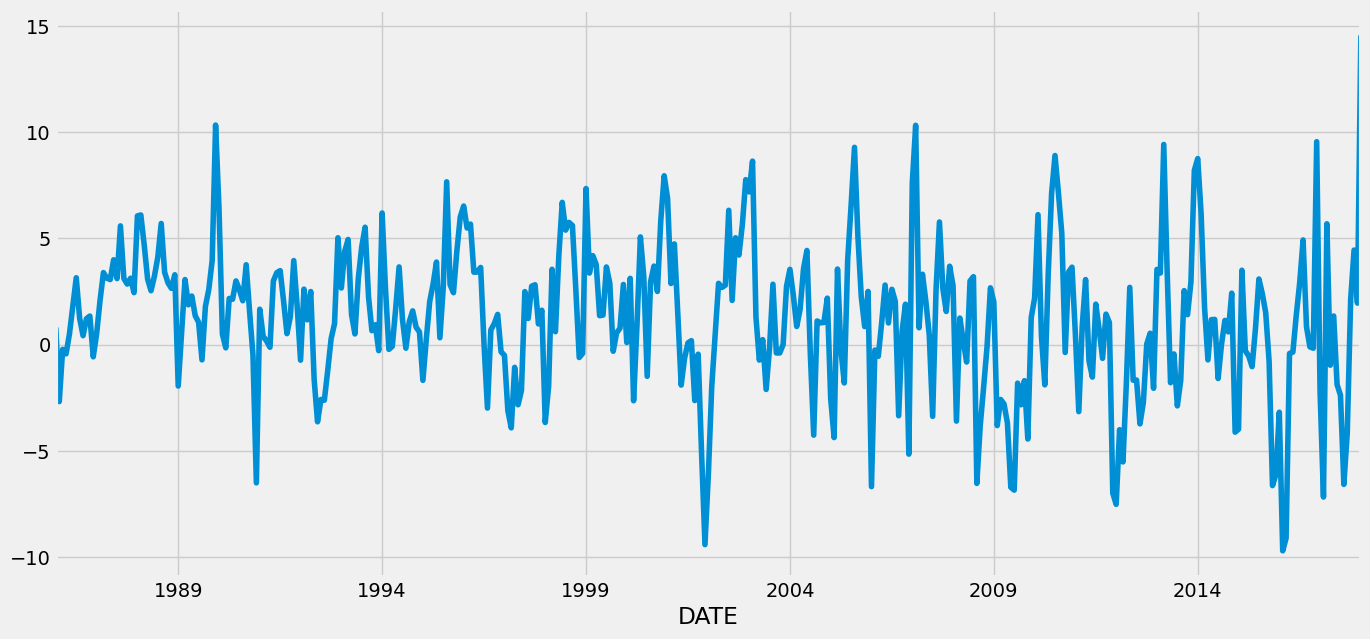

In [37]:
df['Season_lag'].dropna().plot(figsize=(15,7))

In [38]:
df.head(20)

,Electricity_Usage,One_Lag,Season_lag
DATE,,,
1985-01-01,72.5052,NaN,NaN
1985-02-01,70.6720,-1.8332,NaN
1985-03-01,62.4502,-8.2218,NaN
1985-04-01,57.4714,-4.9788,NaN
1985-05-01,55.3151,-2.1563,NaN
1985-06-01,58.0904,2.7753,NaN
1985-07-01,62.6202,4.5298,NaN
1985-08-01,63.2485,0.6283,NaN
1985-09-01,60.5846,-2.6639,NaN


In [41]:
# ADF on One_Lag and Season_Lag
adfuller_fit(df['One_Lag'].dropna())

Critical Values:-7.104890882267334
p-value:4.0777865655388604e-10
Lags used:14
Observations Used:381
T-Values:{'1%': -3.4476305904172904, '5%': -2.869155980820355, '10%': -2.570827146203181}


In [43]:
adfuller_fit(df['Season_lag'].dropna())

Critical Values:-5.67348202338176
p-value:8.812644938088942e-07
Lags used:12
Observations Used:372
T-Values:{'1%': -3.4480516066132636, '5%': -2.869340997473759, '10%': -2.5709257824604}


The p-value of both One-Lag and Season_lag are <0.05, hence null hypothesis is rejected and data is stationary

# Decision making on the AR, MA parameters

In [44]:
#import autocorrelation function(acf) and partial autocorrelation function(pacf) plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

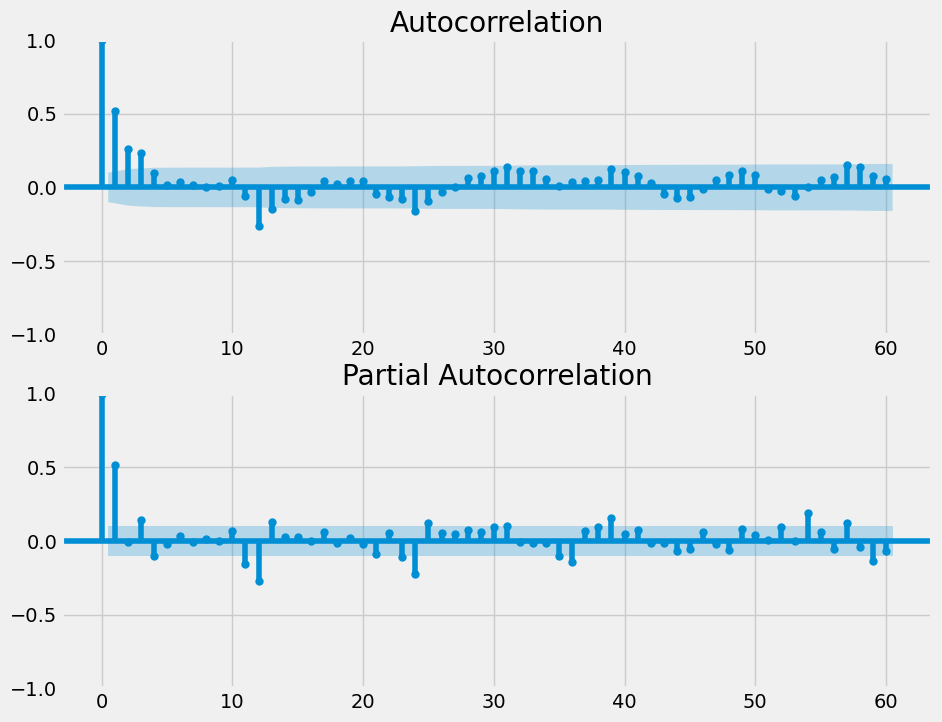

In [55]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsaplots.plot_acf(df['Season_lag'].dropna(),lags=60,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsaplots.plot_pacf(df['Season_lag'].dropna(),lags=60,ax=ax2)

In [56]:
# For non-seasonal assumption
# pacf tapers immediately after the first point. the immediate shutdown a good initial point for AR is p = 1 
# acf usuallly tapers and decays gradually to 0, but for this case it exhibits a similar pattern to pacf. hence q can also = 1 
# however initial focus will be on AR so a model of (1,1,0) will be choosen for the model not accounting for seasonality


In [64]:
#import ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [65]:
model = ARIMA(df['One_Lag'],order = (1,1,0))
model_fit = model.fit()

/Users/temp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/temp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/temp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [66]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                One_Lag   No. Observations:                  397
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1416.695
Date:                Tue, 26 Sep 2023   AIC                           2837.390
Time:                        17:00:21   BIC                           2845.353
Sample:                    01-01-1985   HQIC                          2840.545
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1411      0.047      2.994      0.003       0.049       0.233
sigma2        73.3745      5.783     12.688      0.000      62.040      84.709
===================================================================================
Ljung-Box (L1) (Q):                   1.14   Jarque-Bera (JB):                 9.75
Prob(Q):                              0.29   Prob(JB):                         0.01
Heteroskedasticity (H):               2.96   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='DATE'>

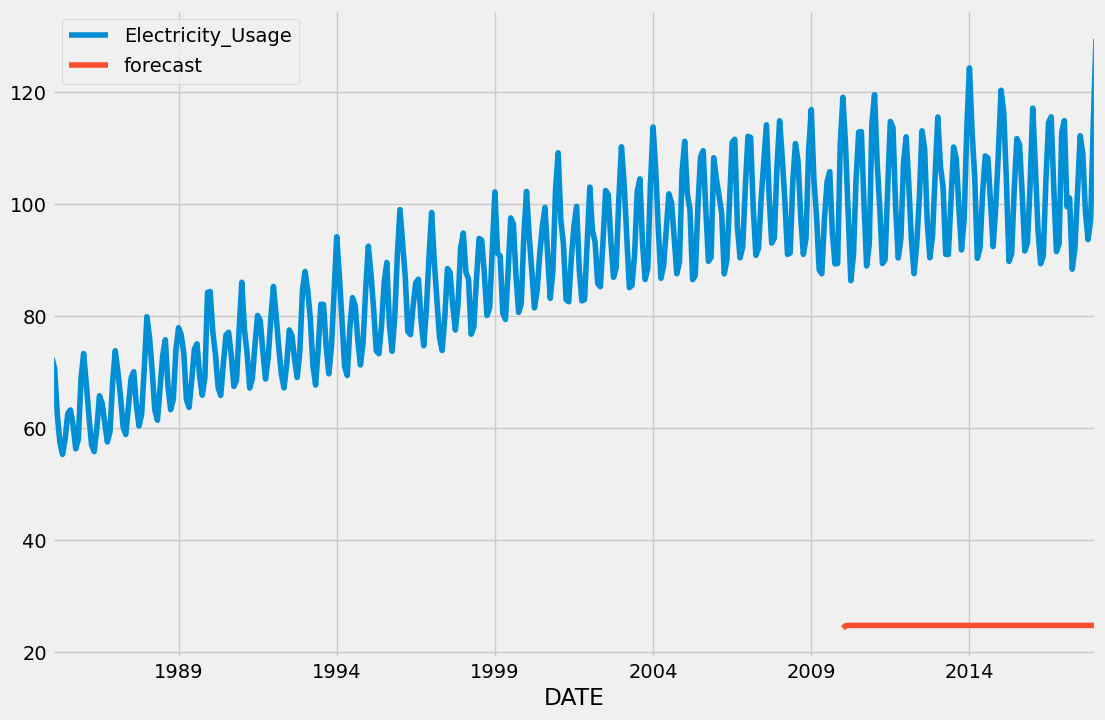

In [76]:
df['forecast']=model_fit.predict(start=300,end=397,dynamic=True)
df[['Electricity_Usage','forecast']].plot(figsize=(12,8))

In [72]:
df['Electricity_Usage'].count()

397

In [78]:
#Not accounting for seasonality led to inaccurate forecasting
# Altering the model for q= 1
model_2 = ARIMA(df['One_Lag'],order = (1,1,1))
model_2_fit = model_2.fit()


/Users/temp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/temp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/temp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [80]:
model_2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                One_Lag   No. Observations:                  397
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1350.331
Date:                Tue, 26 Sep 2023   AIC                           2706.662
Time:                        17:06:19   BIC                           2718.606
Sample:                    01-01-1985   HQIC                          2711.394
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3805      0.085      4.502      0.000       0.215       0.546
ma.L1         -0.9999      5.451     -0.183      0.854     -11.683       9.683
sigma2        51.7598    281.597      0.184      0.854    -500.159     603.679
===================================================================================
Ljung-Box (L1) (Q):                  24.58   Jarque-Bera (JB):                 3.30
Prob(Q):                              0.00   Prob(JB):                         0.19
Heteroskedasticity (H):               2.83   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='DATE'>

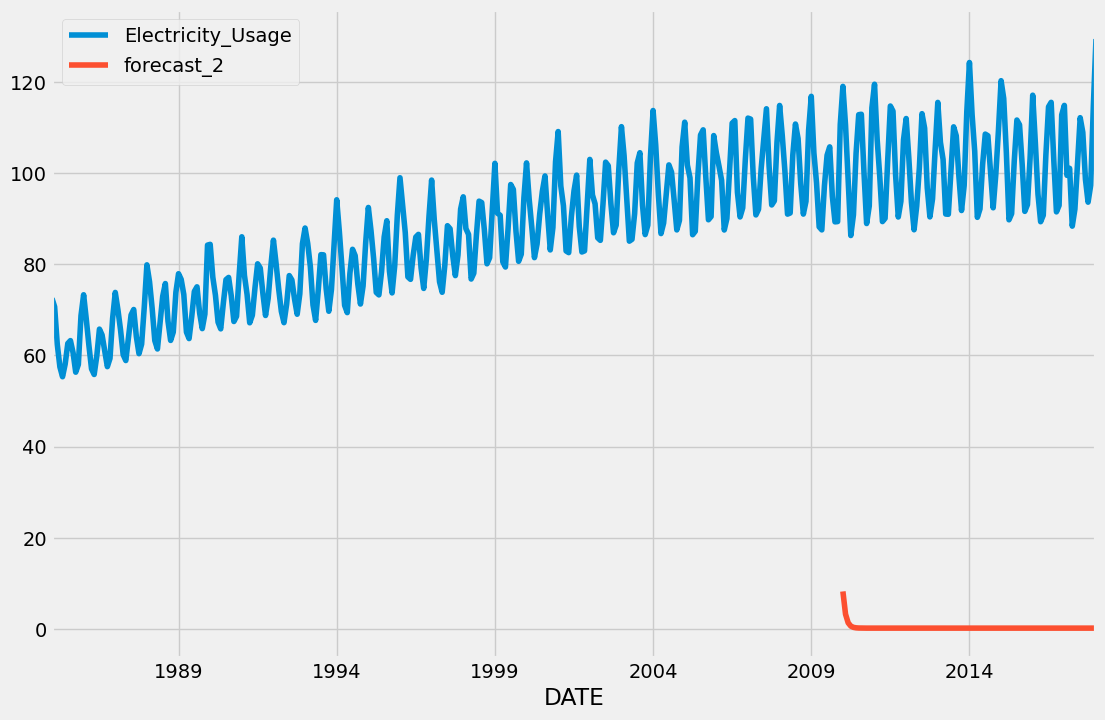

In [81]:
df['forecast_2']=model_2_fit.predict(start=300,end=397,dynamic=True)
df[['Electricity_Usage','forecast_2']].plot(figsize=(12,8))

In [ ]:
#similar results with the consideration of the MA model

# Accounting for seasonality


In [84]:
sarimax_model= sm.tsa.statespace.SARIMAX(df['Electricity_Usage'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
sarimax_results = sarimax_model.fit()

/Users/temp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/temp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33499D+00    |proj g|=  1.05413D-01

At iterate    5    f=  2.25169D+00    |proj g|=  4.08884D-02

At iterate   10    f=  2.23832D+00    |proj g|=  7.92442D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   6.117D-06   2.238D+00
  F =   2.2383201823971524     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<AxesSubplot:xlabel='DATE'>

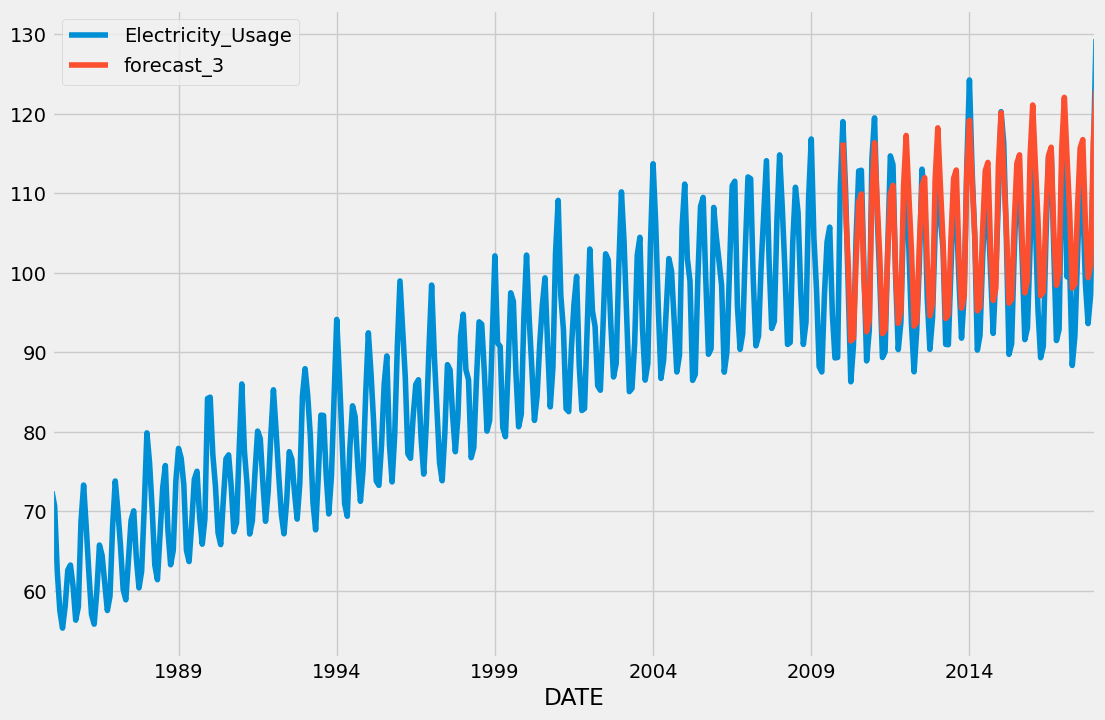

In [85]:
df['forecast_3']=sarimax_results.predict(start=300,end=397,dynamic=True)
df[['Electricity_Usage','forecast_3']].plot(figsize=(12,8))

# Sarimax Notes
- With the SARIMAX model, seasonality has been captured by the model, resulting in a more similar pattern of output


In [86]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [87]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)


In [88]:
future_datest_df.tail()

,Electricity_Usage,One_Lag,Season_lag,forecast,forecast_2,forecast_3
2019-08-01,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-01,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-01,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
forecast_df=pd.concat([df,future_datest_df])

<AxesSubplot:>

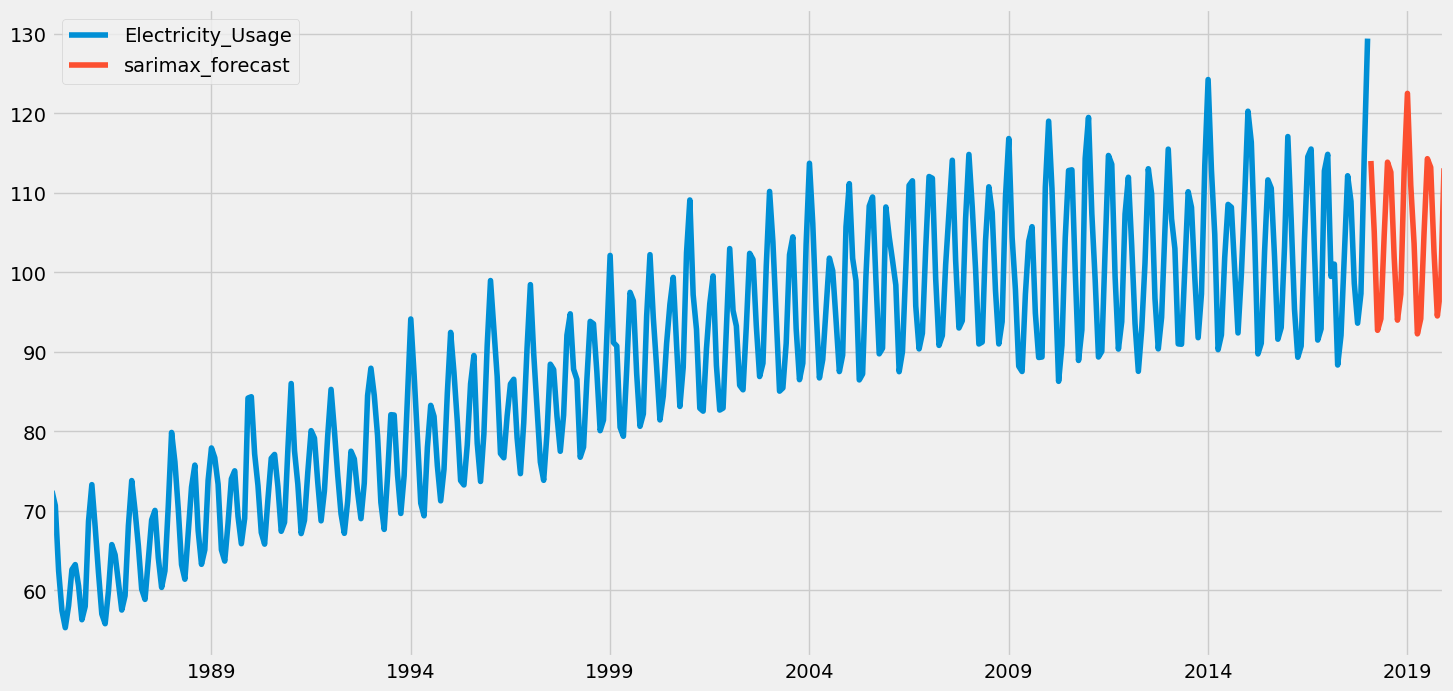

In [95]:
forecast_df['sarimax_forecast'] = sarimax_results.predict(start = 397, end = 700, dynamic= True)  
forecast_df[['Electricity_Usage', 'sarimax_forecast']].plot(figsize=(16, 8)) 

# Final Notes
- The SARIMAX model has captured the seasonality and could forecast the electricity usage for the following period
- Improvements could possibly be made by adjusting the (p,d,q) values however overtuning may lead to overfitting 
- With the data used, capturing the trend and seasonality is the most important part which the model is able to do 
